In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image

%matplotlib inline

In [2]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold=0.6):
    
    #Compute box scores
    box_scores = box_confidence * box_class_probs

    #Find the box_classes using the max box_scores, keep track of the corresponding score
    box_classes = tf.math.argmax(box_scores, axis=-1)
    box_class_scores = tf.reduce_max(box_scores, axis=-1)

    #Create a filtering mask based on "box_class_scores" by using "threshold". 
    filtering_mask = box_class_scores >= threshold

    #Apply the mask to box_class_scores, boxes and box_classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

In [3]:
tf.random.set_seed(10)
box_confidence = tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
box_class_probs = tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = 0.5)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.shape))
print("boxes.shape = " + str(boxes.shape))
print("classes.shape = " + str(classes.shape))

scores[2] = 9.270486
boxes[2] = [ 4.6399336  3.2303846  4.431282  -2.202031 ]
classes[2] = 8
scores.shape = (1789,)
boxes.shape = (1789, 4)
classes.shape = (1789,)


In [4]:
def iou(box1, box2):

    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2.
    xi1 = max(box1_x1, box2_x1)
    yi1 = max(box1_y1, box2_y1)
    xi2 = min(box1_x2, box2_x2)
    yi2 = min(box1_y2, box2_y2)
    
    inter_width = max(xi2 - xi1, 0)
    inter_height = max(yi2 - yi1, 0)
    inter_area = inter_width * inter_height
    
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

In [5]:
## Test case 1: boxes intersect
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4)
print("iou for intersecting boxes = " + str(iou(box1, box2)))

##Test case 2: boxes do not intersect
box1 = (1,2,3,4)
box2 = (5,6,7,8)
print("iou for non-intersecting boxes = " + str(iou(box1,box2)))

##Test case 3: boxes intersect at vertices only
box1 = (1,1,2,2)
box2 = (2,2,3,3)
print("iou for boxes that only touch at vertices = " + str(iou(box1,box2)))

##Test case 4: boxes intersect at edge only
box1 = (1,1,3,3)
box2 = (2,3,3,4)
print("iou for boxes that only touch at edges = " + str(iou(box1,box2)))

iou for intersecting boxes = 0.14285714285714285
iou for non-intersecting boxes = 0.0
iou for boxes that only touch at vertices = 0.0
iou for boxes that only touch at edges = 0.0


In [6]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=max_boxes, iou_threshold=iou_threshold)
    
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [7]:
tf.random.set_seed(10)
scores = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([54, 4], mean=1, stddev=4, seed = 1)
classes = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)

print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

scores[2] = 8.147684
boxes[2] = [ 6.0797963   3.743308    1.3914018  -0.34089637]
classes[2] = 1.7079165
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [8]:
def yolo_boxes_to_corners(box_xy, box_wh):
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])

In [9]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):


    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs

    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)
    
    boxes = scale_boxes(boxes, image_shape) 

    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes

In [10]:
tf.random.set_seed(10)
yolo_outputs = (tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
scores, boxes, classes = yolo_eval(yolo_outputs)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

scores[2] = 171.60194
boxes[2] = [-1240.3483 -3212.5881  -645.78    2024.3052]
classes[2] = 16
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [11]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608)

In [12]:
yolo_model = load_model("model_data/", compile=False)

In [13]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 608, 608, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 608, 608, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 608, 608, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 608, 608, 32)         0         ['batch_normalizati

 chNormalization)                                                                                 
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)   (None, 38, 38, 512)          0         ['batch_normalization_8[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 38, 38, 256)          131072    ['leaky_re_lu_8[0][0]']       
                                                                                                  
 batch_normalization_9 (Bat  (None, 38, 38, 256)          1024      ['conv2d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 leaky_re_

 tchNormalization)                                                                                
                                                                                                  
 conv2d_20 (Conv2D)          (None, 38, 38, 64)           32768     ['leaky_re_lu_12[0][0]']      
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)  (None, 19, 19, 1024)         0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_20 (Ba  (None, 38, 38, 64)           256       ['conv2d_20[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_19

In [14]:
def predict(image_file):

    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=100)
    # Display the results 
    output_image = Image.open(os.path.join("out", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Found 3 boxes for images/0025.jpg
car 0.65 (664, 296) (705, 321)
car 0.58 (436, 298) (484, 331)
car 0.34 (487, 297) (517, 318)


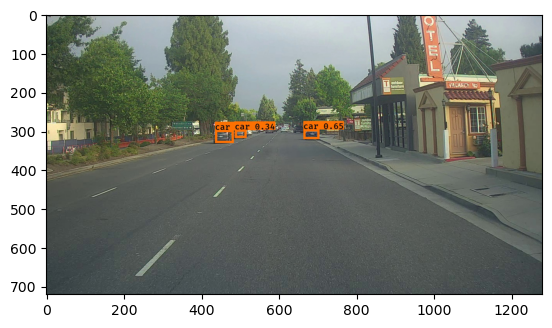

In [16]:
out_scores, out_boxes, out_classes = predict("0025.jpg")